# TF-IDF Information Retrieval System Demo

This notebook demonstrates the complete TF-IDF information retrieval pipeline including:
- Document loading and preprocessing
- TF-IDF vectorization
- Document ranking with cosine similarity
- Rocchio relevance feedback
- Ablation studies
- Performance evaluation and visualization

## 1. Setup and Imports

In [4]:
# Standard library imports
import os
import sys
import json
import pickle
from collections import defaultdict, Counter

# Data manipulation
import numpy as np
import pandas as pd

# NLP and IR
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Import project utilities
from src.utils import load_docs, save_json, save_pickle, save_sparse_matrix

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")

✓ All imports successful!


## 2. Load and Explore Dataset

In [16]:
# Load documents
docs, titles = load_docs("data/News_Category_Dataset_v3.json")

print(f"Total documents: {len(docs):,}")
print(f"Total titles: {len(titles):,}")
print(f"\nSample document:")
print(f"Title: {titles[0]}")
print(f"Text: {docs[0][:200]}...")

Total documents: 209,527
Total titles: 209,527

Sample document:
Title: Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters
Text: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall....


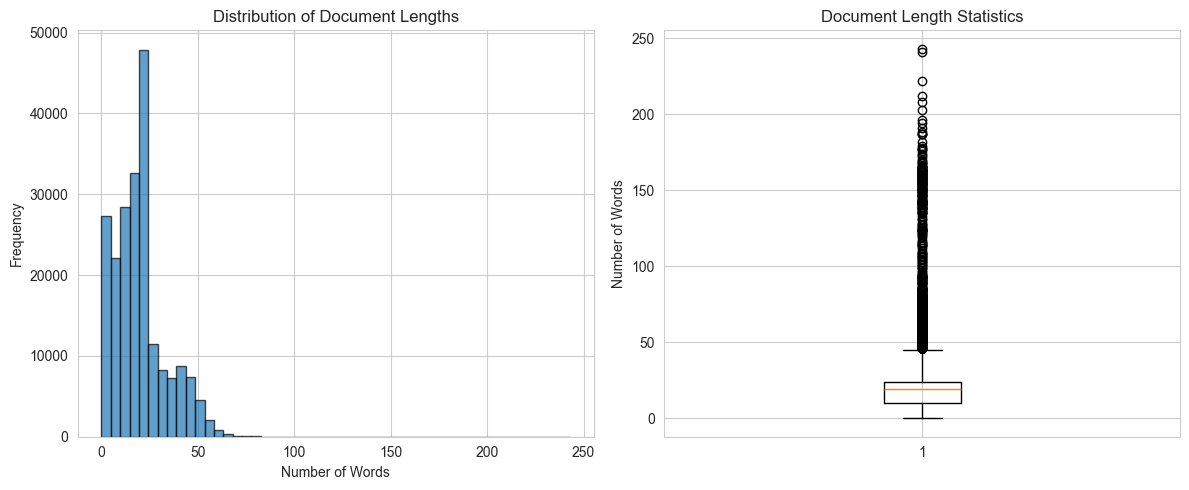

Mean document length: 19.7 words
Median document length: 19.0 words
Min/Max: 0 / 243 words


In [6]:
# Analyze document lengths
doc_lengths = [len(doc.split()) for doc in docs]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(doc_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(doc_lengths, vert=True)
plt.ylabel('Number of Words')
plt.title('Document Length Statistics')

plt.tight_layout()
plt.show()

print(f"Mean document length: {np.mean(doc_lengths):.1f} words")
print(f"Median document length: {np.median(doc_lengths):.1f} words")
print(f"Min/Max: {min(doc_lengths)} / {max(doc_lengths)} words")

## 3. Build TF-IDF Vectorizer

In [17]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 1)
)

# Fit and transform documents
X = vectorizer.fit_transform(docs)

print(f"Document-term matrix shape: {X.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_):,}")
print(f"Matrix sparsity: {(1 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")
print(f"\nTop 20 features by IDF:")

# Get top features by IDF
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_
top_idf_idx = np.argsort(idf_scores)[-20:]

for idx in reversed(top_idf_idx):
    print(f"  {feature_names[idx]}: {idf_scores[idx]:.3f}")

Document-term matrix shape: (209527, 10000)
Vocabulary size: 10,000
Matrix sparsity: 99.92%

Top 20 features by IDF:
  alright: 10.208
  telescope: 10.162
  prague: 10.162
  toyota: 10.162
  bossy: 10.162
  lambert: 10.162
  lupita: 10.117
  virtues: 10.117
  dsm: 10.117
  attracts: 10.117
  maui: 10.117
  muffins: 10.117
  nike: 10.075
  millionaire: 10.075
  mart: 10.075
  faculty: 10.075
  dimension: 10.075
  planets: 10.075
  lapse: 10.075
  latina: 10.075


## 4. Document Ranking

In [8]:
def rank_query(query, vectorizer, X, k=10):
    """
    Rank documents for a given query using cosine similarity.
    """
    query_vec = vectorizer.transform([query])
    similarities = cosine_similarity(query_vec, X).ravel()
    top_indices = np.argsort(similarities)[::-1][:k]
    return [(idx, similarities[idx]) for idx in top_indices]

# Test with a sample query
test_query = "climate change and global warming"
results = rank_query(test_query, vectorizer, X, k=5)

print(f"Query: '{test_query}'\n")
print("Top 5 Results:")
print("=" * 80)

for rank, (doc_id, score) in enumerate(results, 1):
    print(f"\n{rank}. Score: {score:.4f}")
    print(f"   Title: {titles[doc_id]}")
    print(f"   Text: {docs[doc_id][:150]}...")

Query: 'climate change and global warming'

Top 5 Results:

1. Score: 0.7790
   Title: Climate Change Will Ruin Wine Eventually, So You May As Well Drink It All Now
   Text: Global warming is terrorizing our terroir....

2. Score: 0.6271
   Title: Facing Rising Seas, Remote Alaskan Village Votes To Move (Again)
   Text: Climate change has all but swallowed Shishmaref....

3. Score: 0.5931
   Title: John Kasich Actually Believes in Climate Change. But He Doesn't Want to Fix It.
   Text: He says he doesn't "want to overreact" to global warming....

4. Score: 0.5703
   Title: Learning From a Winter of Extremes
   Text: Forecasters expect 2016 to be the warmest year ever recorded. Models suggest this is primarily because of the long term warming trend caused by man-ma...

5. Score: 0.5637
   Title: Climate Oscillations and the Global Warming Faux Pause
   Text: No, climate change is not experiencing a hiatus. No, there is not currently a "pause" in global warming. Despite widespread such c

## 5. Interactive Query Interface

In [9]:
def search_documents(query, top_k=5):
    """
    Interactive search function with formatted output.
    """
    results = rank_query(query, vectorizer, X, k=top_k)
    
    print(f"\n{'='*80}")
    print(f"Query: '{query}'")
    print(f"{'='*80}\n")
    
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"{rank}. [Score: {score:.4f}]")
        print(f"   📰 {titles[doc_id]}")
        print(f"   📝 {docs[doc_id][:200]}...")
        print()
    
    return results

# Try different queries
queries = [
    "election results",
    "earthquake Japan",
    "space mission launch"
]

for q in queries:
    search_documents(q, top_k=3)


Query: 'election results'

1. [Score: 0.7411]
   📰 Donald Trump Learns How To Take A Joke In 'SNL' Opening Monologue
   📝 With middling results....

2. [Score: 0.7411]
   📰 Did Mickey Mouse's Pants Wreck His Sex Life? We Have Science On This.
   📝 The results are both nutty and ballsy....

3. [Score: 0.6943]
   📰 This Hair Stylist Is Helping Trans Youth Transform Into Their Authentic Selves
   📝 "Affirmative action has a new face after the election results,"...


Query: 'earthquake Japan'

1. [Score: 0.6132]
   📰 'Ice Wall' Is Japan's Last-Ditch Effort To Contain Fukushima Radiation
   📝 Five years after the earthquake and tsunami, Japan is still picking up the pieces....

2. [Score: 0.6010]
   📰 Black Friday Got Really Out Of Hand At A Nike Store Near Seattle
   📝 "Like an earthquake leveled the place."...

3. [Score: 0.4863]
   📰 After The Tohoku Earthquake: 'I Gave Up My Family For Dead' (PHOTOS)
   📝 On March 11 of last year, just minutes after the earthquake, I woke to the sound 

## 6. Rocchio Relevance Feedback

In [18]:
def rocchio_feedback(query, relevant_docs, non_relevant_docs, 
                     vectorizer, X, alpha=1.0, beta=0.75, gamma=0.15, k=10):
    """
    Implement Rocchio relevance feedback.
    
    Args:
        query: Original query string
        relevant_docs: List of relevant document IDs
        non_relevant_docs: List of non-relevant document IDs
        alpha: Weight for original query
        beta: Weight for relevant documents
        gamma: Weight for non-relevant documents
    """
    # Get original query vector
    query_vec = vectorizer.transform([query]).toarray()
    
    # Get relevant and non-relevant document vectors
    rel_vecs = X[relevant_docs].toarray() if relevant_docs else np.zeros((0, X.shape[1]))
    non_rel_vecs = X[non_relevant_docs].toarray() if non_relevant_docs else np.zeros((0, X.shape[1]))
    
    # Apply Rocchio formula
    new_query = alpha * query_vec.copy()
    
    if rel_vecs.shape[0] > 0:
        new_query += beta * rel_vecs.mean(axis=0)
    
    if non_rel_vecs.shape[0] > 0:
        new_query -= gamma * non_rel_vecs.mean(axis=0)
    
    # Compute similarities with updated query
    similarities = (X.dot(new_query.T)).ravel()
    top_indices = np.argsort(similarities)[::-1][:k]
    
    return [(idx, similarities[idx]) for idx in top_indices]

# Example: Search and apply feedback
query = "artificial intelligence"

# Initial search
print("Initial Search Results:")
initial_results = search_documents(query, top_k=5)

# Simulate user feedback (mark first 2 as relevant, next 2 as non-relevant)
relevant = [initial_results[0][0], initial_results[1][0]]
non_relevant = [initial_results[2][0], initial_results[3][0]]

print(f"\n{'='*80}")
print("Applying Rocchio Feedback...")
print(f"Relevant docs: {relevant}")
print(f"Non-relevant docs: {non_relevant}")
print(f"{'='*80}\n")

# Apply Rocchio
rocchio_results = rocchio_feedback(query, relevant, non_relevant, vectorizer, X, k=5)

print("Rocchio Refined Results:")
for rank, (doc_id, score) in enumerate(rocchio_results, 1):
    print(f"{rank}. [Score: {score:.4f}]")
    print(f"   📰 {titles[doc_id]}")
    print(f"   📝 {docs[doc_id][:200]}...")
    print()

Initial Search Results:

Query: 'artificial intelligence'

1. [Score: 0.7273]
   📰 This Groundbreaking Algorithm Can Spot Sepsis Before Doctors
   📝 Five ways artificial intelligence can improve our lives....

2. [Score: 0.6859]
   📰 World's Business Elite Are Stressed About Our Robotic Future
   📝 In Davos, not everyone is excited about artificial intelligence....

3. [Score: 0.6270]
   📰 Amazon Is Making It Easier For Companies To Track You
   📝 By Adrienne LaFrance Like “big data” and “social media” before it, the term “artificial intelligence” has become so buzzworthy...

4. [Score: 0.5817]
   📰 Why Are Digital Assistants Like Siri Given Female Voices?
   📝 At an artificial intelligence conference, a good question gets a surprising answer....

5. [Score: 0.5441]
   📰 Trump Launches Another Sexist Tweet In Newest Attack On 'Morning Joe' Hosts
   📝 The president has insulted Mika Brzezinski's intelligence, again....


Applying Rocchio Feedback...
Relevant docs: [np.int64(53723), np.i

## 7. Evaluation Metrics

In [11]:
def precision_at_k(relevant_docs, retrieved_docs, k):
    """Calculate Precision@K"""
    retrieved_k = retrieved_docs[:k]
    relevant_retrieved = len(set(retrieved_k) & set(relevant_docs))
    return relevant_retrieved / k if k > 0 else 0

def recall_at_k(relevant_docs, retrieved_docs, k):
    """Calculate Recall@K"""
    retrieved_k = retrieved_docs[:k]
    relevant_retrieved = len(set(retrieved_k) & set(relevant_docs))
    return relevant_retrieved / len(relevant_docs) if len(relevant_docs) > 0 else 0

def average_precision(relevant_docs, retrieved_docs):
    """Calculate Average Precision"""
    if not relevant_docs:
        return 0.0
    
    score = 0.0
    num_hits = 0.0
    
    for i, doc in enumerate(retrieved_docs, 1):
        if doc in relevant_docs:
            num_hits += 1.0
            score += num_hits / i
    
    return score / len(relevant_docs)

# Example evaluation
query = "technology innovation"
results = rank_query(query, vectorizer, X, k=20)
retrieved = [doc_id for doc_id, _ in results]

# Simulate ground truth (in practice, this would come from manual judgments)
np.random.seed(42)
relevant = list(np.random.choice(retrieved[:10], size=5, replace=False))

print(f"Query: '{query}'\n")
print(f"Precision@5:  {precision_at_k(relevant, retrieved, 5):.3f}")
print(f"Precision@10: {precision_at_k(relevant, retrieved, 10):.3f}")
print(f"Recall@10:    {recall_at_k(relevant, retrieved, 10):.3f}")
print(f"AP:           {average_precision(relevant, retrieved):.3f}")

Query: 'technology innovation'

Precision@5:  0.400
Precision@10: 0.500
Recall@10:    1.000
AP:           0.711


## 8. Ablation Study: Impact of Preprocessing

Ablation Study Results:
 P@5  P@10  Recall@10      MAP            Pipeline
0.25  0.25   0.410119 0.377965  A_stop_on_stem_off
0.20  0.30   0.499851 0.393622 B_stop_off_stem_off
0.24  0.18   0.261905 0.393446   C_stop_on_stem_on
0.24  0.22   0.319048 0.409841  D_stop_off_stem_on



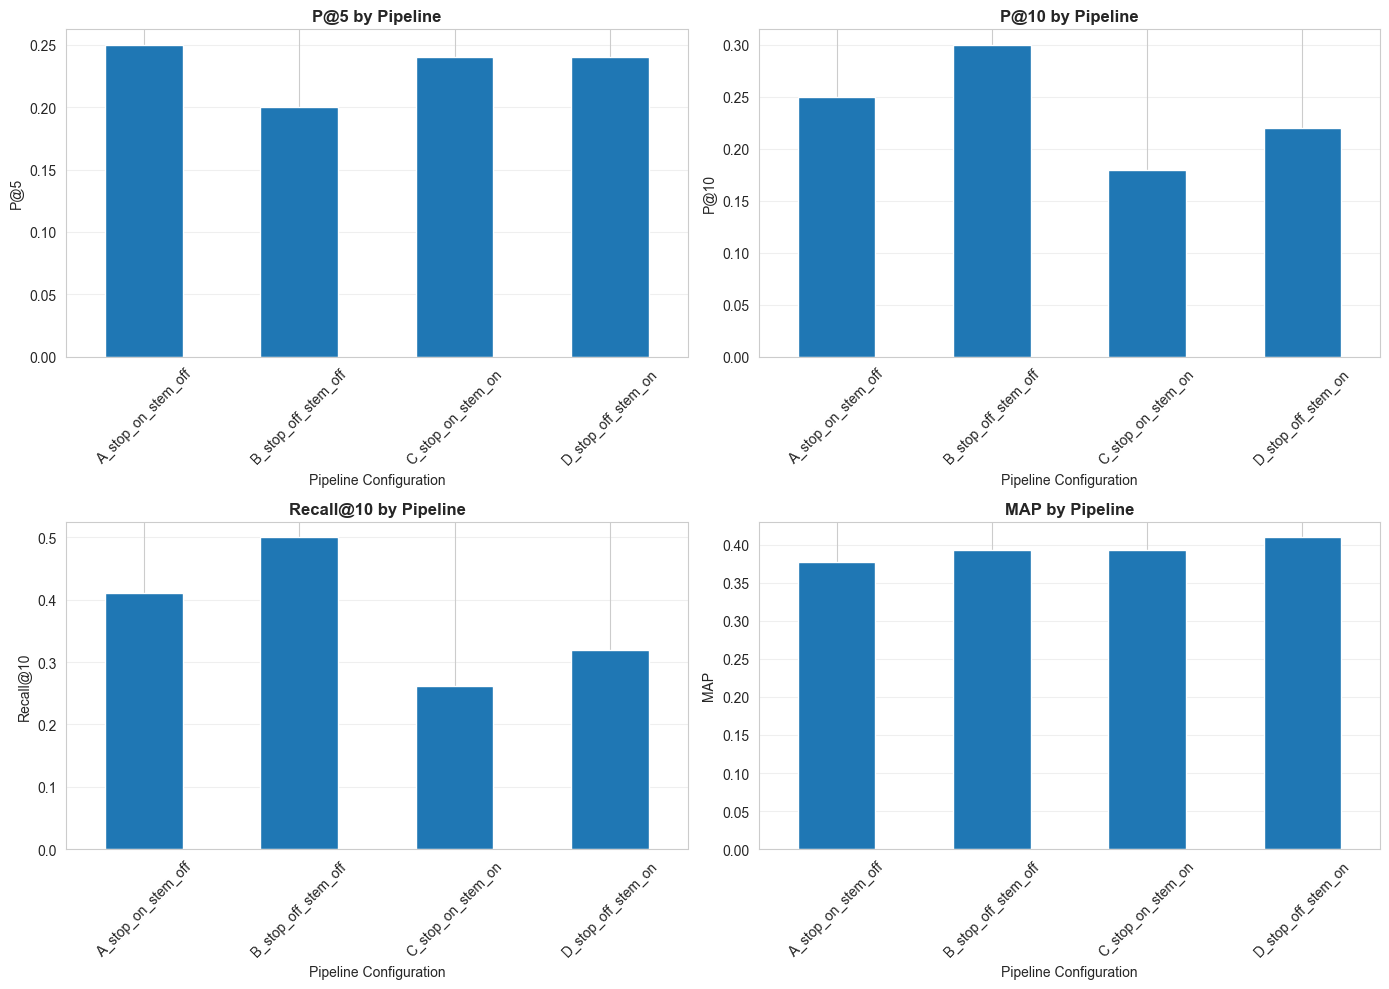


Best Pipeline for Each Metric:
P@5         : A_stop_on_stem_off (0.2500)
P@10        : B_stop_off_stem_off (0.3000)
Recall@10   : B_stop_off_stem_off (0.4999)
MAP         : D_stop_off_stem_on (0.4098)


In [12]:
# Load ablation results if available
ablation_file = "outputs/ablation/ablation_metrics.csv"

if os.path.exists(ablation_file):
    ablation_df = pd.read_csv(ablation_file)
    
    print("Ablation Study Results:")
    print("=" * 80)
    print(ablation_df.to_string(index=False))
    print()
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ['P@5', 'P@10', 'Recall@10', 'MAP']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        ablation_df.plot(x='Pipeline', y=metric, kind='bar', ax=ax, legend=False)
        ax.set_title(f'{metric} by Pipeline', fontsize=12, fontweight='bold')
        ax.set_xlabel('Pipeline Configuration')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best pipeline for each metric
    print("\nBest Pipeline for Each Metric:")
    print("=" * 80)
    for metric in metrics:
        best_idx = ablation_df[metric].idxmax()
        best_pipeline = ablation_df.loc[best_idx, 'Pipeline']
        best_score = ablation_df.loc[best_idx, metric]
        print(f"{metric:12s}: {best_pipeline} ({best_score:.4f})")
else:
    print(f"Ablation results not found. Run: python -m src.ablation_pipelines && python -m src.run_ablation")

## 9. Baseline vs Rocchio Comparison

In [13]:
# Load evaluation results if available
baseline_file = "outputs/results/results.csv"
rocchio_file = "outputs/results/results_rocchio.csv"

if os.path.exists(baseline_file) and os.path.exists(rocchio_file):
    # This would require running evaluate.py first
    # For now, show how to visualize if data exists
    print("To compare Baseline vs Rocchio:")
    print("1. Run: python -m src.rank_and_eval")
    print("2. Fill judgments_template.csv with relevance judgments")
    print("3. Run: python -m src.evaluate")
    print("4. Run: python -m src.plot_results")
    print("\nPlots will be saved in outputs/plots/")
else:
    print("Results files not found. Follow the pipeline in the README.md")

To compare Baseline vs Rocchio:
1. Run: python -m src.rank_and_eval
2. Fill judgments_template.csv with relevance judgments
3. Run: python -m src.evaluate
4. Run: python -m src.plot_results

Plots will be saved in outputs/plots/


## 10. Vocabulary Analysis

Top 20 Most Discriminative Terms (Highest IDF):
     term       idf
  alright 10.208090
   toyota 10.161570
   prague 10.161570
  lambert 10.161570
    bossy 10.161570
telescope 10.161570
     maui 10.117118
 attracts 10.117118
      dsm 10.117118
  virtues 10.117118
  muffins 10.117118
   lupita 10.117118
  crashes 10.074559
  planets 10.074559
dimension 10.074559
strapless 10.074559
 doctrine 10.074559
   erotic 10.074559
     mart 10.074559
  closure 10.074559


Top 20 Most Common Terms (Lowest IDF):
     term      idf
     week 4.856006
       ve 4.785871
president 4.777492
      way 4.765260
     want 4.734820
    years 4.731826
     know 4.702565
    world 4.655500
      don 4.619416
     make 4.617992
    trump 4.583557
      day 4.550767
     life 4.532479
     year 4.443048
     said 4.329288
     like 4.185912
     time 4.138563
   people 4.129029
     just 4.115166
      new 4.038181


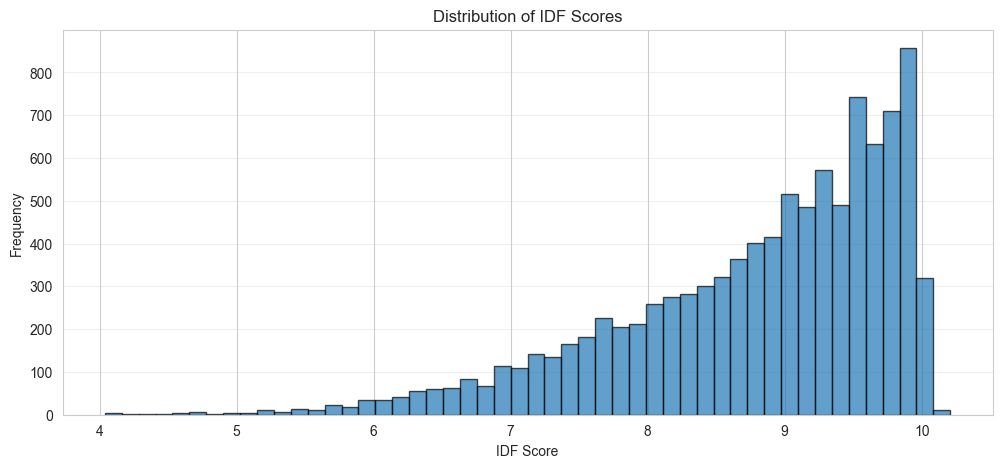

In [14]:
# Analyze vocabulary
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# Create vocabulary dataframe
vocab_df = pd.DataFrame({
    'term': feature_names,
    'idf': idf_scores
}).sort_values('idf', ascending=False)

print("Top 20 Most Discriminative Terms (Highest IDF):")
print(vocab_df.head(20).to_string(index=False))

print("\n" + "="*80)
print("\nTop 20 Most Common Terms (Lowest IDF):")
print(vocab_df.tail(20).to_string(index=False))

# Plot IDF distribution
plt.figure(figsize=(12, 5))
plt.hist(idf_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Scores')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 11. Save Vectorizer and Matrix (Optional)

In [15]:
# Optionally save the vectorizer and matrix for later use
save_notebook_outputs = False  # Set to True to save

if save_notebook_outputs:
    os.makedirs("outputs", exist_ok=True)
    save_pickle(vectorizer, "outputs/tfidf_vectorizer_notebook.pkl")
    save_sparse_matrix(X, "outputs/X_notebook.npz")
    print("✓ Saved vectorizer and matrix to outputs/")
else:
    print("Set save_notebook_outputs=True to save vectorizer and matrix")

Set save_notebook_outputs=True to save vectorizer and matrix


## Summary

This notebook demonstrated:

1. ✅ Loading and exploring the news dataset
2. ✅ Building TF-IDF vectorizer and document-term matrix
3. ✅ Ranking documents using cosine similarity
4. ✅ Interactive query interface
5. ✅ Rocchio relevance feedback implementation
6. ✅ Evaluation metrics (Precision, Recall, AP)
7. ✅ Ablation study visualization
8. ✅ Vocabulary analysis

### Next Steps:

- Experiment with different queries
- Try different Rocchio parameters (alpha, beta, gamma)
- Compare preprocessing configurations
- Analyze query-specific performance
- Implement additional ranking algorithms